<a href="https://colab.research.google.com/github/astroid19/fastbook/blob/master/deep_learning_recommendation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Recommendation Model (Amazon DataSet)

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import random

### EDA

In [ ]:
# Loading data
books_data = pd.read_csv('/content/books.csv', on_bad_lines='skip', encoding='latin-1', sep=';', dtype={'Year-Of-Publication': 'str'})
ratings = pd.read_csv('/content/ratings.csv', on_bad_lines='skip', encoding='latin-1', sep=';')

In [ ]:
# Convert 'Year-Of-Publication' to numeric format, ignoring errors
books_data['Year-Of-Publication'] = pd.to_numeric(books_data['Year-Of-Publication'], errors='coerce')

# Remove rows with missing values in 'Year-Of-Publication'
books_data = books_data.dropna(subset=['Year-Of-Publication'])

# Merge data on 'ISBN' and select relevant columns
merged_data = ratings.merge(books_data[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']], on='ISBN', how='left')
merged_data = merged_data[['User-ID', 'ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Book-Rating']]


In [ ]:
# Convert data to numeric format
merged_data['Book-Rating'] = merged_data['Book-Rating'].astype(float)

In [ ]:
# Selecting and reordering columns in the DataFrame
merged_data = merged_data[['User-ID', 'Book-Rating',
                           'ISBN', 'Book-Title',
                           'Book-Author', 'Year-Of-Publication',
                           'Publisher']]

# Displaying the first few rows of the modified DataFrame
merged_data.head()

,User-ID,Book-Rating,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,0.0,034545104X,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books
1,276726,5.0,0155061224,Rites of Passage,Judith Rae,2001.0,Heinle
2,276727,0.0,0446520802,The Notebook,Nicholas Sparks,1996.0,Warner Books
3,276729,3.0,052165615X,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press
4,276729,6.0,0521795028,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press


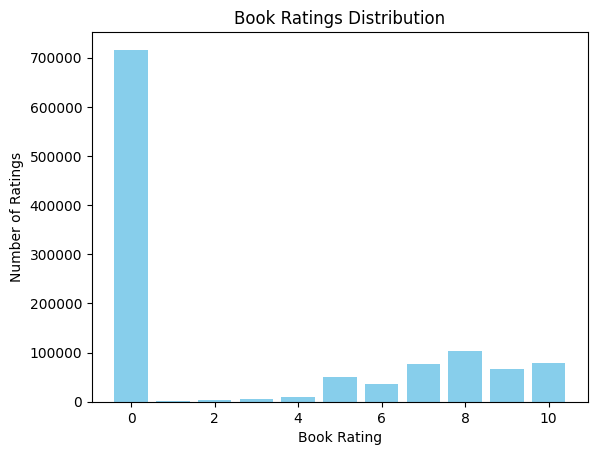

In [ ]:
# Rating distribution
ratings_distribution = merged_data['Book-Rating'].value_counts().sort_index()

# Creating a bar plot
plt.bar(ratings_distribution.index, ratings_distribution.values, color='skyblue')
plt.xlabel('Book Rating')
plt.ylabel('Number of Ratings')
plt.title('Book Ratings Distribution')
plt.show()

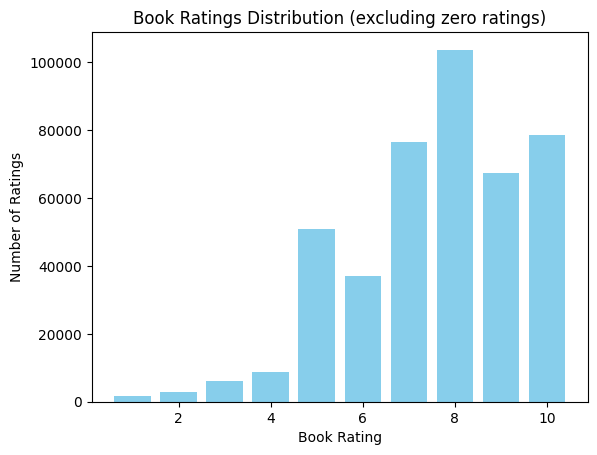

In [ ]:
# Removing entries with zero ratings
merged_data = merged_data[merged_data['Book-Rating'] != 0]

# Recreating the ratings distribution plot
ratings_distribution = merged_data['Book-Rating'].value_counts().sort_index()

# Creating a bar plot
plt.bar(ratings_distribution.index, ratings_distribution.values, color='skyblue')
plt.xlabel('Book Rating')
plt.ylabel('Number of Ratings')
plt.title('Book Ratings Distribution (excluding zero ratings)')
plt.show()


In [ ]:
# Removing rows with NaN values
merged_data = merged_data.dropna()

# Checking that NaN values have been removed
print("Number of NaN values after removal:", merged_data.isna().any().sum())
merged_data.shape

Number of NaN values after removal: 0


(383838, 7)

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383838 entries, 1 to 1149778
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              383838 non-null  int64  
 1   Book-Rating          383838 non-null  float64
 2   ISBN                 383838 non-null  object 
 3   Book-Title           383838 non-null  object 
 4   Book-Author          383838 non-null  object 
 5   Year-Of-Publication  383838 non-null  float64
 6   Publisher            383838 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 23.4+ MB


In [ ]:
merged_data['User-ID'].describe()

count    383838.000000
mean     136031.515777
std       80482.514055
min           8.000000
25%       67591.000000
50%      133790.000000
75%      206219.000000
max      278854.000000
Name: User-ID, dtype: float64

In [ ]:
# Assuming df is your DataFrame
merged_data['userid'] = merged_data['User-ID'].astype('category').cat.codes + 1
merged_data['bookid'] = merged_data['ISBN'].astype('category').cat.codes + 1
merged_data.bookid.min()

1

In [ ]:
# Shuffle the data
merged_data = merged_data.sample(frac=1).reset_index(drop=True)

In [ ]:
# Displaying the first few rows of the modified DataFrame
merged_data.head()

,User-ID,Book-Rating,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,userid,bookid
0,182459,10.0,0743225406,The Shipping News : A Novel,Annie Proulx,2001.0,Scribner,44555,86676
1,53456,5.0,0671743260,SONGS OF THE DOOMED : SONGS OF THE DOOMED (Tho...,Hunter S. Thompson,1991.0,Pocket,13117,76805
2,140935,10.0,0962959103,The Teenage Liberation Handbook: How to Quit S...,Grace Llewellyn,1991.0,Lowry House Pub,34563,116338
3,129505,9.0,0142000361,The Florabama Ladies' Auxiliary &amp; Sewing C...,Lois Battle,2002.0,Penguin Books,31737,12280
4,126487,5.0,0553575074,Starcatcher,Patricia Potter,1997.0,Bantam Books,30981,66874


In [ ]:
merged_data.ISBN.describe()

count         383838
unique        149832
top       0316666343
freq             707
Name: ISBN, dtype: object

In [ ]:
# Converting 'book ID' to numeric format
num_users = len(merged_data['userid'].unique())
num_books = len(merged_data['bookid'].unique())
num_users, num_books

(68091, 149832)

In [ ]:
# Splitting data into training and test sets
train_data, test_data = train_test_split(merged_data, test_size=0.2)

# Displaying the sizes of the obtained sets
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 307070
Test set size: 76768


### Device

In [ ]:
# Check if a GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Creating DataLoaders

In [ ]:
# Data transformation into PyTorch-compatible format
class RecommendationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'user_id': torch.tensor(self.data.iloc[idx]['userid'], dtype=torch.long).to(device),
            'book_id': torch.tensor(self.data.iloc[idx]['bookid'], dtype=torch.long).to(device),
            'rating': torch.tensor(self.data.iloc[idx]['Book-Rating'], dtype=torch.float).to(device),
        }

# Creating instances of the Dataset class for training and testing
train_dataset = RecommendationDataset(train_data)
test_dataset = RecommendationDataset(test_data)

# Creating DataLoader for training and testing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Model Architecture

In [ ]:
# Creating the model
class RecommendationModel(nn.Module):
    def __init__(self, num_users, num_books, embedding_size=50, hidden_size=64):
        super(RecommendationModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.book_embedding = nn.Embedding(num_books, embedding_size)

        self.layers = nn.Sequential(
            nn.Linear(embedding_size * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        # self.layers = nn.Sequential(
        #     nn.Linear(embedding_size * 2, hidden_size),
        #     nn.ReLU(),
        #     nn.Dropout(dropout_prob),
        #     nn.Linear(hidden_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Dropout(dropout_prob),
        #     nn.Linear(hidden_size, 1)
        # )
    def forward(self, user_ids, book_ids):
        user_embeds = self.user_embedding(user_ids)
        book_embeds = self.book_embedding(book_ids)
        concat_embeds = torch.cat((user_embeds, book_embeds), dim=1)

        return self.layers(concat_embeds).view(-1)

### Model Fit

In [ ]:
# Creating an instance of the model
model = RecommendationModel(num_users, num_books)

# Move the model to the CUDA device if available
model = model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()

# Setting lr and wd values
desired_lr = 1e-3
# desired_wd = 2e-2

# Creating an optimizer with the specified lr and wd values
# optimizer = optim.Adam(model.parameters(), lr=desired_lr, weight_decay=desired_wd)
optimizer = optim.Adam(model.parameters(), lr=desired_lr)

# Move optimizer's state to device
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

# Accuracy metric
def accuracy(predictions, targets):
    predictions = predictions.round()
    correct = (predictions == targets).sum().item()
    total = targets.size(0)
    return correct / total

# Creating lists to store loss and accuracy data
train_losses = []
train_accuracies = []

# Training the model with tqdm and evaluating accuracy on the test set
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0.0
    total_accuracy = 0.0
    # Using tqdm to create a progress indicator
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch"):
        user_ids = torch.clamp(batch['user_id'], min=0, max=num_users - 1)
        book_ids = torch.clamp(batch['book_id'], min=0, max=num_books - 1)
        ratings = batch['rating'].to(device)

        optimizer.zero_grad()

        outputs = model(user_ids, book_ids)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy(outputs, ratings)

    # Calculate average loss and accuracy
    average_loss = total_loss / len(train_loader)
    average_accuracy = total_accuracy / len(train_loader)

    # Add values to the lists
    train_losses.append(average_loss)
    train_accuracies.append(average_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {average_accuracy:.4f}")

print("Training completed.")

Epoch 1/30: 100%|██████████| 4798/4798 [03:17<00:00, 24.25batch/s]


Epoch 1/30, Loss: 4.5819, Accuracy: 0.2078


Epoch 2/30: 100%|██████████| 4798/4798 [03:14<00:00, 24.68batch/s]


Epoch 2/30, Loss: 2.7393, Accuracy: 0.2626


Epoch 3/30: 100%|██████████| 4798/4798 [03:25<00:00, 23.38batch/s]


Epoch 3/30, Loss: 2.3644, Accuracy: 0.3018


Epoch 4/30: 100%|██████████| 4798/4798 [03:15<00:00, 24.49batch/s]


Epoch 4/30, Loss: 2.0532, Accuracy: 0.3435


Epoch 5/30: 100%|██████████| 4798/4798 [03:16<00:00, 24.44batch/s]


Epoch 5/30, Loss: 1.7751, Accuracy: 0.3900


Epoch 6/30: 100%|██████████| 4798/4798 [03:13<00:00, 24.79batch/s]


Epoch 6/30, Loss: 1.5256, Accuracy: 0.4377


Epoch 7/30: 100%|██████████| 4798/4798 [03:10<00:00, 25.19batch/s]


Epoch 7/30, Loss: 1.3010, Accuracy: 0.4852


Epoch 8/30: 100%|██████████| 4798/4798 [03:11<00:00, 25.09batch/s]


Epoch 8/30, Loss: 1.1042, Accuracy: 0.5326


Epoch 9/30: 100%|██████████| 4798/4798 [03:19<00:00, 24.07batch/s]


Epoch 9/30, Loss: 0.9341, Accuracy: 0.5772


Epoch 10/30: 100%|██████████| 4798/4798 [03:24<00:00, 23.51batch/s]


Epoch 10/30, Loss: 0.7913, Accuracy: 0.6186


Epoch 11/30: 100%|██████████| 4798/4798 [03:21<00:00, 23.85batch/s]


Epoch 11/30, Loss: 0.6721, Accuracy: 0.6574


Epoch 12/30: 100%|██████████| 4798/4798 [03:18<00:00, 24.15batch/s]


Epoch 12/30, Loss: 0.5731, Accuracy: 0.6899


Epoch 13/30: 100%|██████████| 4798/4798 [03:14<00:00, 24.65batch/s]


Epoch 13/30, Loss: 0.4938, Accuracy: 0.7182


Epoch 14/30: 100%|██████████| 4798/4798 [03:14<00:00, 24.63batch/s]


Epoch 14/30, Loss: 0.4277, Accuracy: 0.7453


Epoch 15/30: 100%|██████████| 4798/4798 [03:15<00:00, 24.57batch/s]


Epoch 15/30, Loss: 0.3735, Accuracy: 0.7671


Epoch 16/30: 100%|██████████| 4798/4798 [03:18<00:00, 24.18batch/s]


Epoch 16/30, Loss: 0.3294, Accuracy: 0.7860


Epoch 17/30: 100%|██████████| 4798/4798 [03:14<00:00, 24.65batch/s]


Epoch 17/30, Loss: 0.2931, Accuracy: 0.8020


Epoch 18/30: 100%|██████████| 4798/4798 [03:14<00:00, 24.63batch/s]


Epoch 18/30, Loss: 0.2619, Accuracy: 0.8182


Epoch 19/30: 100%|██████████| 4798/4798 [03:18<00:00, 24.13batch/s]


Epoch 19/30, Loss: 0.2365, Accuracy: 0.8306


Epoch 20/30: 100%|██████████| 4798/4798 [03:16<00:00, 24.42batch/s]


Epoch 20/30, Loss: 0.2147, Accuracy: 0.8419


Epoch 21/30: 100%|██████████| 4798/4798 [03:16<00:00, 24.48batch/s]


Epoch 21/30, Loss: 0.1966, Accuracy: 0.8529


Epoch 22/30: 100%|██████████| 4798/4798 [03:26<00:00, 23.25batch/s]


Epoch 22/30, Loss: 0.1805, Accuracy: 0.8622


Epoch 23/30: 100%|██████████| 4798/4798 [03:20<00:00, 23.93batch/s]


Epoch 23/30, Loss: 0.1670, Accuracy: 0.8703


Epoch 24/30: 100%|██████████| 4798/4798 [03:14<00:00, 24.68batch/s]


Epoch 24/30, Loss: 0.1558, Accuracy: 0.8776


Epoch 25/30: 100%|██████████| 4798/4798 [03:13<00:00, 24.77batch/s]


Epoch 25/30, Loss: 0.1457, Accuracy: 0.8847


Epoch 26/30: 100%|██████████| 4798/4798 [03:09<00:00, 25.28batch/s]


Epoch 26/30, Loss: 0.1370, Accuracy: 0.8911


Epoch 27/30: 100%|██████████| 4798/4798 [03:10<00:00, 25.19batch/s]


Epoch 27/30, Loss: 0.1292, Accuracy: 0.8965


Epoch 28/30: 100%|██████████| 4798/4798 [03:16<00:00, 24.47batch/s]


Epoch 28/30, Loss: 0.1223, Accuracy: 0.9019


Epoch 29/30: 100%|██████████| 4798/4798 [03:16<00:00, 24.46batch/s]


Epoch 29/30, Loss: 0.1164, Accuracy: 0.9071


Epoch 30/30: 100%|██████████| 4798/4798 [03:15<00:00, 24.51batch/s]

Epoch 30/30, Loss: 0.1110, Accuracy: 0.9111
Training completed.


### Lost & Accuracity Plot

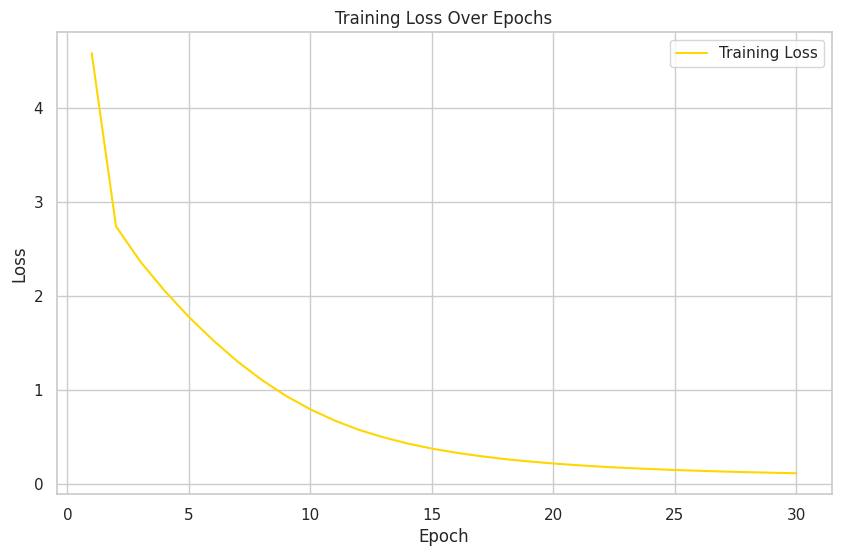

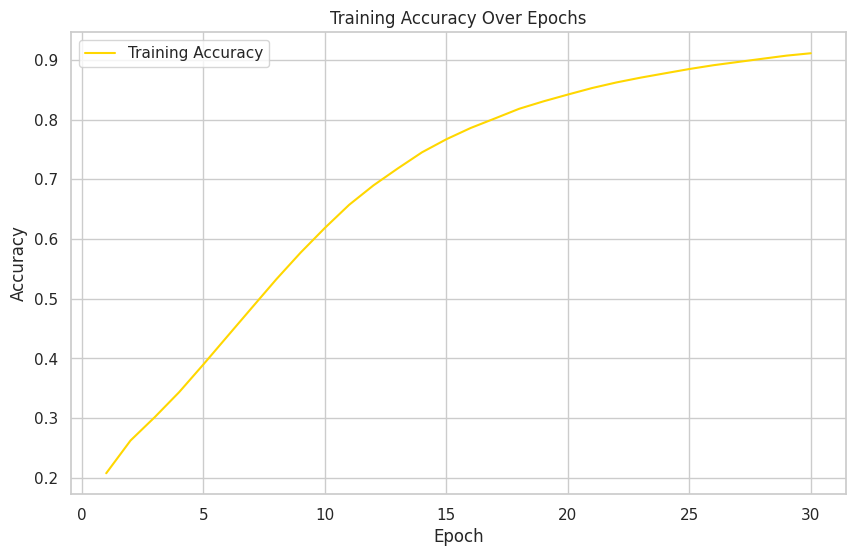

In [ ]:
# Creating Seaborn style
sns.set(style="whitegrid")

# Creating a loss plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, num_epochs + 1), y=train_losses, label='Training Loss', color='gold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Creating an accuracy plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, num_epochs + 1), y=train_accuracies, label='Training Accuracy', color='gold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()

### Saving Model

In [ ]:
import torch
import datetime
import os

# Your existing model and training code

# Saving the model weights with date and time in the filename
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f'/content/model_DLRM_{current_datetime}.pth'
torch.save(model.state_dict(), model_filename)
